# Selección de variables

## Machine Learning. Grado en Ciencia de datos

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import random

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, SelectFdr, SelectFpr, SelectPercentile, SelectFwe

import sklearn.datasets as dt

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
#Random Seed para reproducibilidad
semilla=1000
np.random.seed(semilla)

### Eliminación recursiva de variables

En esta sección vamos a implementar el proceso de eliminación recursiva de variables, un método de tipo wrapper en el que, en este caso, vamos a utilizar un Random Forest cómo técnica de aprendizaje para evaluar los diferentes subconjunto de variables. 

Primero vamos a cargar el data set de ejemplo

In [3]:
cancer_X, cancer_y = dt.load_breast_cancer(return_X_y=True, as_frame=True)

Como podemos ver estamos ante un dataset con 30 atributos

In [4]:
cancer_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Primero vamos a entrenar un random forest básico con todas las variables para saber la importancia de las mismas y tener un "baseline" para ver si es posible mejorarlo con la eliminación de algunas variables. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(cancer_X, cancer_y, test_size=0.2, random_state=semilla)
rf = RandomForestClassifier(random_state=semilla)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1000)

Una vez entrenado el modelo analizamos la exactitud del modelo en el conjunto de test

In [6]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9298245614035088


Como podemos apreciar hemos alcanzado una exactitud de 0,93. En el atributo `feature_importances_` podemos ver la importancia de cada variable calculada como la suma del decremento de la impureza cuando la variable es seleccionada para realizar la partición en un determinado nodo. 

En nuestro ejemplo ésta sería la importancia de las variables. 

In [7]:
rf.feature_importances_

array([0.04982232, 0.0116652 , 0.05118065, 0.04488942, 0.0032389 ,
       0.012802  , 0.06027143, 0.07108648, 0.00305713, 0.0044943 ,
       0.0187292 , 0.0048062 , 0.0152863 , 0.05157467, 0.00192236,
       0.00334694, 0.00538646, 0.00369466, 0.00400236, 0.00341919,
       0.12281049, 0.01613105, 0.15722514, 0.07854847, 0.01125982,
       0.01687003, 0.02630495, 0.13104731, 0.00757444, 0.00755212])

Para poder implementar nuestro proceso de eliminación recursiva de variables tenemos que crear un `Series` con `Pandas` en la que almacenar todas las variables, ordenadas de forma decreciente, la importancia de las variables y el nombre de las mismas como índice de la serie. 

In [8]:
mdi_importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)
mdi_importances.sort_values(ascending = False, inplace=True)

En la siguiente gráfica se muestra la importancia de las variables que se ha obtenido

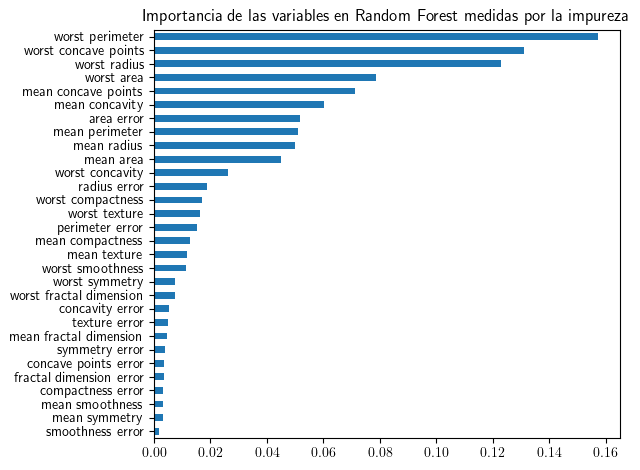

In [9]:
ax = mdi_importances.sort_values(ascending=True).plot.barh()
ax.set_title("Importancia de las variables en Random Forest medidas por la impureza ")
ax.figure.tight_layout()

Ahora ya estamos en disposición de crear nuestro propio algoritmo para la eliminación recursiva de variables. Primero tenemos que definir el rango del número de variables que vamos a explorar. 

In [10]:
min_size = 4
max_size = 30
sizes = range(min_size-1,max_size)

print(sizes)

range(3, 30)


Con ese rango podemos crear el bucle que nos permite implementar la búsqueda recursiva de variables

In [11]:
#Inicializamos la mejor accuracy a la accuracy del caso base
best_accuracy = accuracy

print('La precisión inicial es:')
print(accuracy)

# Creamos un bucle para recorrer el rango "sizes" en orden inverso.
for size in reversed(sizes):
    # creamos dos nuevos conjuntos X_train_rfe e X_test_rfe que sólo contengan las columnas correspondientes
    # variables que hay que comprobar
    print('El número de variables es:')
    print(size)
    
    variables_importantes = mdi_importances.index[:size+1]
    X_train_rfe = X_train[variables_importantes]
    X_test_rfe = X_test[variables_importantes]

    # Entrenamos un clasificador Random Forest y calculamos su precisión utilizando los conjuntos 
    rf_rfe = RandomForestClassifier(random_state=semilla)
    rf_rfe.fit(X_train_rfe, y_train)
    y_pred = rf_rfe.predict(X_test_rfe)
    accuracy = accuracy_score(y_test, y_pred)

    # Si el accuracy obtenido es mayor o igual al best_accuracy hasta el momento
    # actualizar best_accuracy y best_model. 
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_model = rf_rfe
    # imprime el tamaño del conjunto de variables y su accuracy
    print(rf_rfe.n_features_in_," ",accuracy)
print("Mejor número de variables: ", best_model.n_features_in_," Exactitud obtenida: ", best_accuracy)


La precisión inicial es:
0.9298245614035088
El número de variables es:
29
30   0.9298245614035088
El número de variables es:
28
29   0.9298245614035088
El número de variables es:
27
28   0.9385964912280702
El número de variables es:
26
27   0.9385964912280702
El número de variables es:
25
26   0.9298245614035088
El número de variables es:
24
25   0.9298245614035088
El número de variables es:
23
24   0.9298245614035088
El número de variables es:
22
23   0.9298245614035088
El número de variables es:
21
22   0.9122807017543859
El número de variables es:
20
21   0.9385964912280702
El número de variables es:
19
20   0.9298245614035088
El número de variables es:
18
19   0.9298245614035088
El número de variables es:
17
18   0.9385964912280702
El número de variables es:
16
17   0.9473684210526315
El número de variables es:
15
16   0.9298245614035088
El número de variables es:
14
15   0.9210526315789473
El número de variables es:
13
14   0.9298245614035088
El número de variables es:
12
13   0.9

Ahora vamos a repetir el mismo proceso calculando al importancia de las variables con el método de permutación

In [12]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=semilla, n_jobs=-1, scoring='accuracy')
per_importances = pd.Series(result.importances_mean, index=rf.feature_names_in_)

In [13]:
print(type(result.importances_mean))

print(result.importances_mean)

<class 'numpy.ndarray'>
[ 0.          0.00526316  0.          0.          0.          0.
 -0.01315789 -0.02192982  0.          0.          0.00175439  0.
  0.00263158  0.00263158  0.          0.          0.          0.
  0.          0.         -0.0122807   0.00350877 -0.01491228 -0.00614035
  0.          0.00263158 -0.00350877 -0.01315789  0.          0.00087719]


En este este caso podemos apreciar cómo cambian la importancia de las variables con están nueva técnica. 

In [14]:
per_importances.sort_values(ascending=False, inplace=True)
per_importances

mean texture               0.005263
worst texture              0.003509
worst compactness          0.002632
perimeter error            0.002632
area error                 0.002632
radius error               0.001754
worst fractal dimension    0.000877
smoothness error           0.000000
worst symmetry             0.000000
worst smoothness           0.000000
fractal dimension error    0.000000
symmetry error             0.000000
concave points error       0.000000
concavity error            0.000000
mean radius                0.000000
texture error              0.000000
mean fractal dimension     0.000000
mean symmetry              0.000000
mean compactness           0.000000
mean smoothness            0.000000
mean area                  0.000000
mean perimeter             0.000000
compactness error          0.000000
worst concavity           -0.003509
worst area                -0.006140
worst radius              -0.012281
mean concavity            -0.013158
worst concave points      -0

Al igual que hicimos antes, también se pueden ver de forma gráfica. 

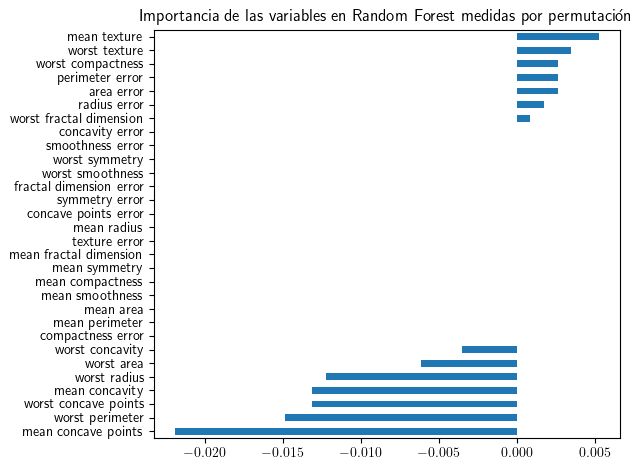

In [15]:
ax = per_importances.sort_values(ascending=True).plot.barh()
ax.set_title("Importancia de las variables en Random Forest medidas por permutación ")
ax.figure.tight_layout()

Valores <= 0: No son importantes,
valores > 0: Son importantes

Para seleccionar las variables mediante eliminación recursiva de variables podemos aplicar el mismo algoritmo que hemos implementado anteriormente. 

In [16]:
#Inicializamos la mejor accuracy a la accuracy del caso base
best_accuracy = accuracy

# Creamos un bucle para recorrer el rango "sizes" en orden inverso.
for size in reversed(sizes):
    # creamos dos nuevos conjuntos X_train_rfe e X_test_rfe que sólo contengan las columnas correspondientes
    # variables que hay que comprobar
    # PON TU CÓDIGO AQUÍ
    variables_importantes = per_importances.index[:size+1]
    X_train_rfe = X_train[variables_importantes]
    X_test_rfe = X_test[variables_importantes]

    # Entrenamos un clasificador Random Forest y calculamos su precisión utilizando los conjuntos 
    # X_train_rfe y X_test_rfe (utiliza random_state=semilla)
    # PON TU CÓDIGO AQUÍ
    rf_rfe = RandomForestClassifier(random_state=semilla)
    rf_rfe.fit(X_train_rfe, y_train)
    y_pred = rf_rfe.predict(X_test_rfe)
    accuracy = accuracy_score(y_test, y_pred)
    # Si el accuracy obtenido es mayor o igual al best_accuracy hasta el momento
    # actualizar best_accuracy y best_model. 
    # PON TU CÓDIGO AQUÍ
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_model = rf_rfe
    # imprime el tamaño del conjunto de variables y su accuracy
    print(rf_rfe.n_features_in_," ",accuracy)
print("Mejor número de variables: ", best_model.n_features_in_," Exactitud obtenida: ", best_accuracy)

30   0.9473684210526315
29   0.9385964912280702
28   0.9298245614035088
27   0.9385964912280702
26   0.956140350877193
25   0.9473684210526315
24   0.9298245614035088
23   0.9385964912280702
22   0.9473684210526315
21   0.956140350877193
20   0.9210526315789473
19   0.9298245614035088
18   0.9473684210526315
17   0.9385964912280702
16   0.9210526315789473
15   0.9298245614035088
14   0.9035087719298246
13   0.9035087719298246
12   0.9210526315789473
11   0.8947368421052632
10   0.9122807017543859
9   0.9035087719298246
8   0.9035087719298246
7   0.9210526315789473
6   0.9210526315789473
5   0.9122807017543859
4   0.8771929824561403
Mejor número de variables:  21  Exactitud obtenida:  0.956140350877193


Aquí va un ejemplo con validación cruzada 

In [17]:
scores = cross_val_score(RandomForestClassifier(random_state=semilla), 
                            X_train, y_train, cv=5, scoring=('accuracy'))
accuracy = scores.mean()
accuracy

0.9494505494505494

In [18]:
#Inicializamos la mejor accuracy a la accuracy del caso base
best_accuracy = accuracy

# Creamos un bucle para recorrer el rango "sizes" en orden inverso.
for size in reversed(sizes):
    # Creamos un nuevos conjunto X_train_rfe que sólo contenga las columnas correspondientes
    # variables que hay que comprobar
    variables_importantes = per_importances.index[:size+1]
    X_train_rfe = X_train[variables_importantes]
    
    # Entrenamos un clasificador Random Forest y calculamos su precisión utilizando la validación cruzada 
    scores = cross_val_score(RandomForestClassifier(random_state=semilla), 
                            X_train_rfe, y_train, cv=5, scoring=('accuracy'))
    accuracy = scores.mean()

    # Si el accuracy obtenido es mayor o igual al best_accuracy hasta el momento
    # actualizar best_accuracy y best_model. 
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_size = size+1
     # imprime el tamaño del conjunto de variables y su accuracy
    print(size+1," ",accuracy)
print('best_size:', best_size, '**** best_accuracy:', best_accuracy)

30   0.9428571428571428
29   0.9516483516483516
28   0.9516483516483516
27   0.9604395604395604
26   0.9604395604395606
25   0.9604395604395604
24   0.9604395604395604
23   0.945054945054945
22   0.9318681318681319
21   0.9428571428571428
20   0.9384615384615385
19   0.9362637362637363
18   0.9362637362637362
17   0.9340659340659341
16   0.9428571428571428
15   0.9384615384615385
14   0.923076923076923
13   0.923076923076923
12   0.9186813186813186
11   0.9142857142857143
10   0.9142857142857143
9   0.9054945054945055
8   0.9010989010989011
7   0.9032967032967033
6   0.8989010989010989
5   0.8989010989010989
4   0.8857142857142858
best_size: 26 **** best_accuracy: 0.9604395604395606


In [19]:
per_importances

mean texture               0.005263
worst texture              0.003509
worst compactness          0.002632
perimeter error            0.002632
area error                 0.002632
radius error               0.001754
worst fractal dimension    0.000877
smoothness error           0.000000
worst symmetry             0.000000
worst smoothness           0.000000
fractal dimension error    0.000000
symmetry error             0.000000
concave points error       0.000000
concavity error            0.000000
mean radius                0.000000
texture error              0.000000
mean fractal dimension     0.000000
mean symmetry              0.000000
mean compactness           0.000000
mean smoothness            0.000000
mean area                  0.000000
mean perimeter             0.000000
compactness error          0.000000
worst concavity           -0.003509
worst area                -0.006140
worst radius              -0.012281
mean concavity            -0.013158
worst concave points      -0

In [20]:
per_importances.index[0:8]

Index(['mean texture', 'worst texture', 'worst compactness', 'perimeter error',
       'area error', 'radius error', 'worst fractal dimension',
       'smoothness error'],
      dtype='object')

### Eliminación recursiva de variables en Scikit-learn
En este apartado vamos a analizar las posibilidades que ofrece Scikit-learn para la eliminación recursiva de variables. Básicamente, la librería nos ofrece dos funciones para implementar esta técnica de eliminación recursiva de variables: `sklearn.feature_selection.RFE()` y `sklearn.feature_selection.RFECV()`

#### RFE()
La función `sklearn.feature_selection.RFE()` tiene como atributos principales:

- **estimator:**  una técnica de aprendizaje supervisado que proporcione información sobre la importancia de las variables a través de los atributos: `coef_` o `feature_importances_`.
- **n_features_to_select (int or float):** un valor entero indicaría el número de variables a seleccionar. En el caso de un valor de tipo `float`, tendría que ser un valor entre 0 y 1 indicando la fracción de variables a seleccionar. Si no se especifica este parámetro se coge la mitad de las variables. 

Una vez ejecutada esta función se devuelve un objeto con los siguientes atributos:

- **clases_:** las etiquetas de las clases cuando el `estimator` es un clasificador. 
- **n_features_ (int):** número de variables a seleccionar. 
- **n_features_int_ (int):** número de variables utilizadas para la selección, disponible siempre y cuando el `estimator` defina este atributo. 
- **features_names_in (ndarray):** array con los nombres de las variables iniciales, disponible sólo en el caso de que todas sean de tipo `string`. 
- **ranking_ (ndarray):** array con la información sobre el ranking de las variables. `ranking_[i]` indica la posición en el ranking de la variable i-ésima. 


Como ejemplo, vamos a aplicar esta función al dataset que hemos utilizado anteriormente. 

In [21]:
n_features_to_select = 8
rfe = RFE(RandomForestClassifier(random_state=semilla), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=1000), n_features_to_select=8)

Ahora podemos ver las variables seleccionadas

In [22]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 mean perimeter
1 mean area
1 mean concavity
1 mean concave points
1 worst radius
1 worst perimeter
1 worst area
1 worst concave points
2 worst concavity
3 worst texture
4 mean radius
5 area error
6 worst smoothness
7 mean texture
8 worst symmetry
9 radius error
10 worst compactness
11 perimeter error
12 concavity error
13 mean compactness
14 concave points error
15 worst fractal dimension
16 mean smoothness
17 texture error
18 fractal dimension error
19 symmetry error
20 mean symmetry
21 compactness error
22 mean fractal dimension
23 smoothness error


La función `sklearn.feature_selection.RFE()` también puede ser incluidas en un `Pipeline`

In [23]:
from sklearn.pipeline import Pipeline
rfe = RFE(RandomForestClassifier(random_state=semilla), n_features_to_select=n_features_to_select)
model = RandomForestClassifier(random_state=semilla)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

Ahora ya podemos evaluar un modelo utilizando el flujo anteriormente definido. 

In [24]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [25]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.951 (0.033)


#### RFECV()

La función `sklearn.feature_selection.RFECV()` ejecuta la función `sklearn.feature_selection.RFE()` dentro de una validación cruzada para, de esta forma seleccionar, de forma automática el número de variables óptimo. Los parámetros principales de esta función son:

- **estimator:**  una técnica de aprendizaje supervisado que proporcione información sobre la importancia de las variables a través de los atributos: `coef_` o `feature_importances_`.
- **min_features_to_select (int):** un valor entero indicando el número mínimo de variables a seleccionar. 
- **cv (int, cross-validation generator):** parámetro para indicar qué tipo de validación cruzada se va a utilizar. Por defecto, si no se indica nada, se realiza un validación cruzada con 5-folds, valor que se puede cambiar indicando el número de folds a utilizar. También se puede pasar como parámetro un `CV splitter`.

Una vez ejecutada esta función se devuelve un objeto con los siguientes atributos:

- **clases_:** las etiquetas de las clases cuando el `estimator` es un clasificador. 
- **cv_results_:** un diccionar con los siguientes valores
    - **split(k)_test_score**: array con los valores de rendimiento en cada fold. 
    - **mean_test_score:** la media de la medida de rendimiento en cada fold.
    - **sd_test_score:** la desviación estándar de la medida de rendimiento en cada fold. 
- **n_features_ (int):** número de variables a seleccionar. 
- **n_features_int_ (int):** número de variables utilizadas para la selección, disponible siempre y cuando el `estimator` defina este atributo. 
- **features_names_in (ndarray):** array con los nombres de las variables iniciales, disponible sólo en el caso de que todas sean de tipo `string`. 
- **ranking_ (ndarray):** array con la información sobre el ranking de las variables. `ranking_[i]` indica la posición en el ranking de la variable i-ésima. 


Como ejemplo, vamos a aplicar esta función al dataset que hemos utilizado anteriormente. 


In [26]:
from sklearn.pipeline import Pipeline
min_features_to_select = 3
rfecv = RFECV(RandomForestClassifier(random_state=semilla), min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

RFECV(estimator=RandomForestClassifier(random_state=1000),
      min_features_to_select=3)

In [27]:
print(f"Número óptimo de variables: {rfecv.n_features_}")
print(f"Exactitud alcanzada: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_]:.3f}")

Número óptimo de variables: 25
Exactitud alcanzada: 0.949


De forma gráfica podemos analizar cómo se ha desarrollado el proceso con cada número de variables seleccionadas y analizar la desviación estándar en la validación cruzada. 

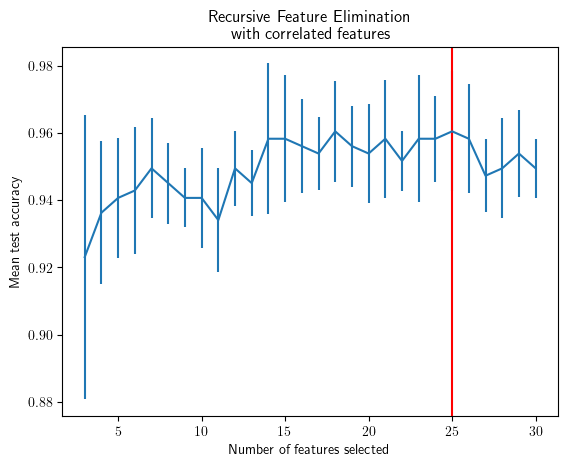

In [28]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.axvline(rfecv.n_features_, color = 'red')
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Eliminación de variables por filtros en Scikit-learn
Los métodos de selección de variables basados en filtros se caracterizan por ser técnicas basadas en test estadísticos univariantes. En `scikit learn` se realizan a través de la función `sklearn.feature_selection.SelectKBest()`. Los principales parámetros de esta función son:

- **score_func:** función utilizada para calcular la importancia de las variables. Se pueden utilizar las siguientes funciones:
    - **f_classif:**, sólo válida para la clasificación y valor por defecto, que calcula el ANOVA entre las etiquetas de clase y las variables y devuelve el pvalue. 
    - **mutual_info_classif**, sólo válida para clasificación, utiliza la medida de información mutua para las etiquetas de clase. 
    - **chi2:** estadístico Chi cuadrado para variables no negativas en problemas de clasificación. 
    - **f_regression:** test estadístico para regresión que primero calcular la correlación cruzada entre cada variable y las etiquetas de clase (**r_regression**)y después las convierte en el estadístico F y pvalues. 
- **k (int):** número de variables a seleccionar. 

El objeto que devuelve esta función tiene los siguientes atributos:

- **scores_:** array con la puntuación obtenida para cada variable. 
- **pvalues_:** array con los pvalues en el caso de que la `score_fun` los calcule. 
- **n_features_int_ (int):** número de variables utilizadas para la selección, disponible siempre y cuando el `estimator` defina este atributo. 
- **features_names_in (ndarray):** array con los nombres de las variables iniciales, disponible sólo en el caso de que todas sean de tipo `string`. 


Otras funciones que se pueden utilizar son:

- **sklearn.feature_selection.SelectPercentile():** selecciona las variables con el puntuación más alta que se encuentran en el percentil indicado por el parámetro `percentile (int)`.
- **sklearn.feature_selection.SelectFpr():** selecciona las variables con los pvalues por debajo de la confianza mediante el test estadístico FPR. La confianza se indica en el parámetro `alpha (float)`.
- **sklearn.feature_selection.SelectFdr():** selecciona las variables con la tasa de falsos descubrimiento (FDR) que se calcula mediante el procedimiento Benjamini-Hochberg. En este caso, el parámetro `alpha (float)` indica el límite superior para el FDR
- **sklearn.feature_selection.SelectFwe():** selecciona las variables con pvalues,  corregidos mediante tasa de error global (FWER), por debajo de del pvalue indicando en el parámetro `alpha (float)`.

Por ejemplo, en nuestro ejemplo, si queremos crear un data set con  las 15 variables con el pvalue más bajo de acuerdo con un test ANOVA, se podría utilizar el siguiente código:


In [29]:
k=15
Kbest = SelectKBest(f_classif, k=k)
X_new = Kbest.fit_transform(cancer_X,cancer_y)
X_new = pd.DataFrame(X_new, columns=Kbest.get_feature_names_out())

Si queremos que devuelva directamente un dataframe hay que indicarle que en la transformación genere un dataframe de pandas mediante `set_output(transform='pandas')`:

In [30]:
k=15
Kbest = SelectKBest(f_classif, k=k).set_output(transform='pandas').fit(cancer_X,cancer_y)
X_new = Kbest.fit_transform(cancer_X,cancer_y)

In [31]:
X_new.describe()

,mean radius,mean perimeter,mean area,mean compactness,mean concavity,mean concave points,radius error,perimeter error,area error,worst radius,worst perimeter,worst area,worst compactness,worst concavity,worst concave points
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,91.969033,654.889104,0.104341,0.088799,0.048919,0.405172,2.866059,40.337079,16.269190,107.261213,880.583128,0.254265,0.272188,0.114606
std,3.524049,24.298981,351.914129,0.052813,0.079720,0.038803,0.277313,2.021855,45.491006,4.833242,33.602542,569.356993,0.157336,0.208624,0.065732
min,6.981000,43.790000,143.500000,0.019380,0.000000,0.000000,0.111500,0.757000,6.802000,7.930000,50.410000,185.200000,0.027290,0.000000,0.000000
25%,11.700000,75.170000,420.300000,0.064920,0.029560,0.020310,0.232400,1.606000,17.850000,13.010000,84.110000,515.300000,0.147200,0.114500,0.064930
50%,13.370000,86.240000,551.100000,0.092630,0.061540,0.033500,0.324200,2.287000,24.530000,14.970000,97.660000,686.500000,0.211900,0.226700,0.099930
75%,15.780000,104.100000,782.700000,0.130400,0.130700,0.074000,0.478900,3.357000,45.190000,18.790000,125.400000,1084.000000,0.339100,0.382900,0.161400
max,28.110000,188.500000,2501.000000,0.345400,0.426800,0.201200,2.873000,21.980000,542.200000,36.040000,251.200000,4254.000000,1.058000,1.252000,0.291000


Si queremos ver la importancia de las variables de forma gráfica bastaría con utilizar el mismo código que hemos utilizado anteriormente. 

In [32]:
Kbest.scores_

array([6.46981021e+02, 1.18096059e+02, 6.97235272e+02, 5.73060747e+02,
       8.36511234e+01, 3.13233079e+02, 5.33793126e+02, 8.61676020e+02,
       6.95274435e+01, 9.34592949e-02, 2.68840327e+02, 3.90947023e-02,
       2.53897392e+02, 2.43651586e+02, 2.55796780e+00, 5.32473391e+01,
       3.90144816e+01, 1.13262760e+02, 2.41174067e-02, 3.46827476e+00,
       8.60781707e+02, 1.49596905e+02, 8.97944219e+02, 6.61600206e+02,
       1.22472880e+02, 3.04341063e+02, 4.36691939e+02, 9.64385393e+02,
       1.18860232e+02, 6.64439606e+01])

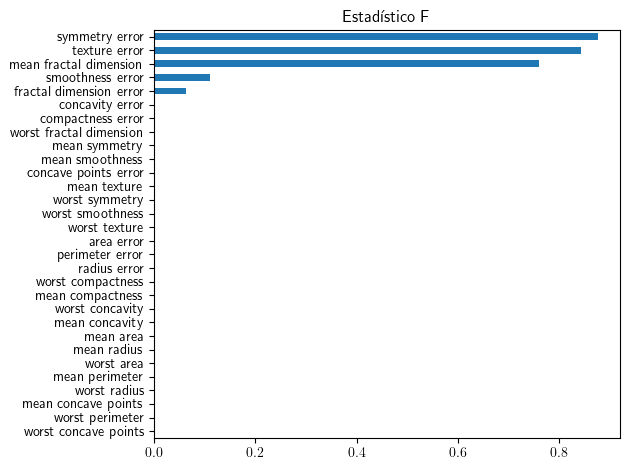

In [33]:
scores = pd.Series(Kbest.pvalues_, index=Kbest.feature_names_in_)
ax = scores.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico F")
ax.figure.tight_layout()

### Ejercicio
Prueba con el resto de funciones, determina los parámetros y realiza una investigación para justificar la elección de parámetros más óptimos

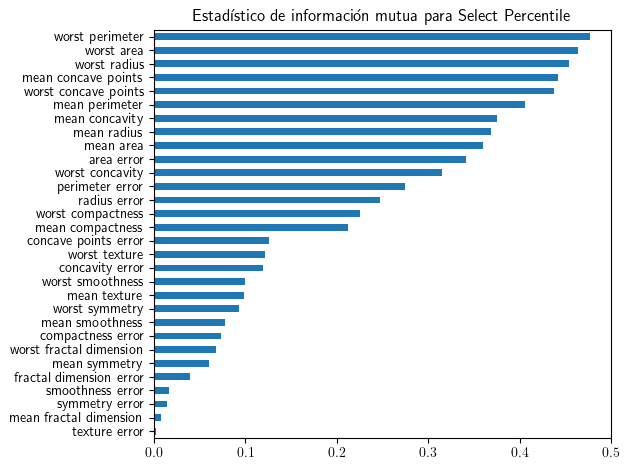

In [34]:
perc = 95
bestperc = SelectPercentile(mutual_info_classif, percentile=perc).set_output(transform='pandas').fit(cancer_X,cancer_y)
Xperc_new = bestperc.fit_transform(cancer_X,cancer_y)

scoresperc = pd.Series(bestperc.scores_, index=bestperc.feature_names_in_)
ax = scoresperc.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico de información mutua para Select Percentile")
ax.figure.tight_layout()

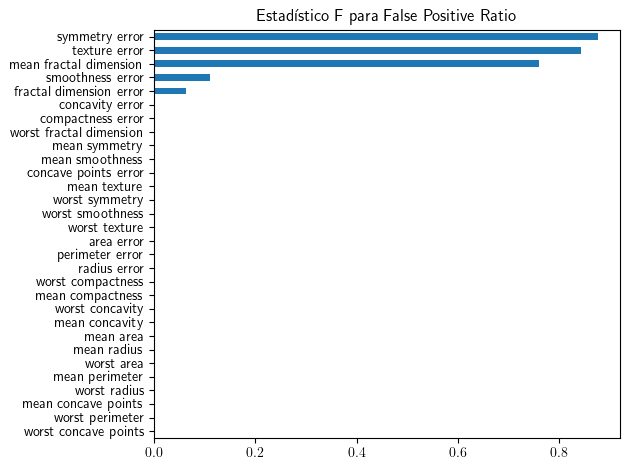

In [35]:
alpha = 0.7
bestfpr = SelectFpr(f_classif, alpha = alpha).set_output(transform='pandas').fit(cancer_X,cancer_y)
Xfpr_new = bestfpr.fit_transform(cancer_X,cancer_y)

scoresfpr = pd.Series(bestfpr.pvalues_, index=bestfpr.feature_names_in_)
ax = scoresfpr.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico F para False Positive Ratio")
ax.figure.tight_layout()

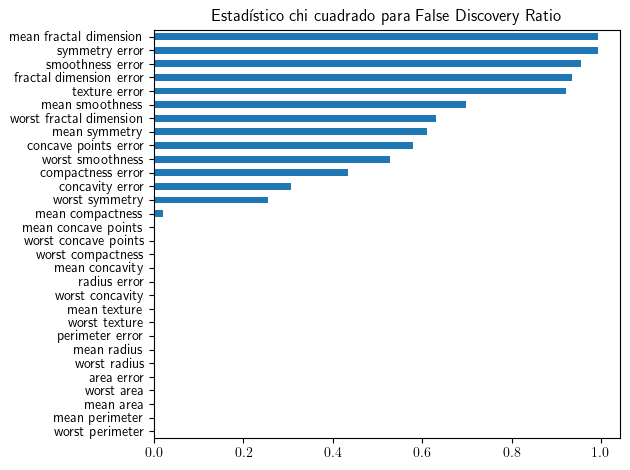

In [36]:
alpha = 0.7
bestfdr = SelectFdr(chi2, alpha = alpha).set_output(transform='pandas').fit(cancer_X,cancer_y)
Xfdr_new = bestfdr.fit_transform(cancer_X,cancer_y)

scoresfdr = pd.Series(bestfdr.pvalues_, index=bestfpr.feature_names_in_)
ax = scoresfdr.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico chi cuadrado para False Discovery Ratio")
ax.figure.tight_layout()

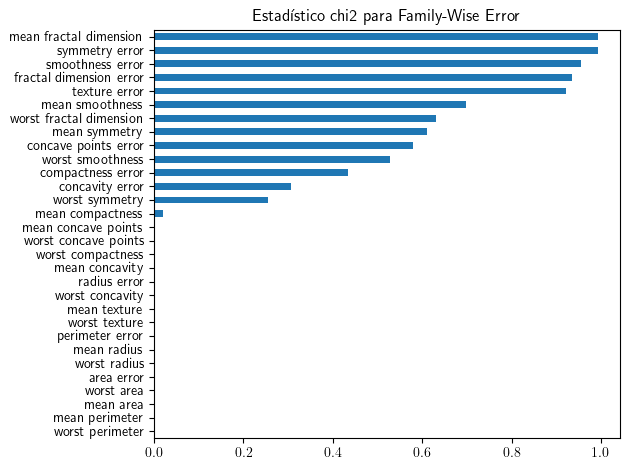

In [37]:
alpha = 0.7
bestfwe = SelectFwe(chi2, alpha = alpha).set_output(transform='pandas').fit(cancer_X,cancer_y)
Xfwe_new = bestfwe.fit_transform(cancer_X,cancer_y)

scoresfwe = pd.Series(bestfwe.pvalues_, index=bestfwe.feature_names_in_)
ax = scoresfwe.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico chi2  para Family-Wise Error")
ax.figure.tight_layout()